# Smart Logistics System - Data Analysis

This notebook performs exploratory data analysis and feature engineering on the DataCo Supply Chain dataset.

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession\
        .builder\
            .appName('gestion logistique')\
            .config('spark.some.config.option' , 'some-value')\
            .config("spark.driver.memory", "8g") \
            .config("spark.executor.memory", "8g") \
                .getOrCreate()


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/18 23:34:38 WARN Utils: Your hostname, epsilon, resolves to a loopback address: 127.0.1.1; using 192.168.11.116 instead (on interface wlp2s0f0)
25/11/18 23:34:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/18 23:34:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/18 23:34:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## 1. Setup and Data Loading

In [2]:
df = spark.read.csv('DataCoSupplyChainDataset.csv' , header=True , inferSchema=True)
df.show(5)


25/11/18 23:34:46 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+--------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+-------------+---------------+-------------------+-------------------+--------------------+------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per c

In [3]:
from pyspark.sql.functions import col
df.filter(col("Delivery Status") == "Shipping canceled").groupBy("Late_delivery_risk").count().show()

+------------------+-----+
|Late_delivery_risk|count|
+------------------+-----+
|                 0| 7754|
+------------------+-----+



In [4]:
df = df.filter(col("Delivery Status") != "Shipping canceled")

df.filter(col("Delivery Status") == "Shipping canceled").groupBy("Late_delivery_risk").count().show()

+------------------+-----+
|Late_delivery_risk|count|
+------------------+-----+
+------------------+-----+



In [5]:
from pyspark.sql.functions import col
df.filter(col("Order Status") == "SUSPECTED_FRAUD").groupBy("Late_delivery_risk").count().show()

+------------------+-----+
|Late_delivery_risk|count|
+------------------+-----+
+------------------+-----+



In [6]:
df.select("Order City").groupBy("Order City").count()

DataFrame[Order City: string, count: bigint]

## 2. Initial Data Exploration

In [7]:
from pyspark.sql.functions import col, expr

numeric_cols = [
    
    "Days for shipment (scheduled)",
    
    "Sales per customer",
    "Order Item Product Price",
  
    "Order Item Total"
]

for c in numeric_cols:
    quantiles = df.approxQuantile(c, [0.25, 0.75], 0.01)
    Q1, Q3 = quantiles
    IQR = Q3 - Q1
    lower = Q1 - 3 * IQR
    upper = Q3 + 3 * IQR
    
    print(f"Column: {c}, Lower bound: {lower}, Upper bound: {upper}")
    
    outliers = df.filter((col(c) < lower) | (col(c) > upper))
    print(f"Number of outliers in {c}: {outliers.count()}")

Column: Days for shipment (scheduled), Lower bound: -4.0, Upper bound: 10.0
Number of outliers in Days for shipment (scheduled): 0
Column: Sales per customer, Lower bound: -321.92002850000006, Upper bound: 671.8700331
Number of outliers in Sales per customer: 450
Column: Order Item Product Price, Lower bound: -399.9700165, Upper bound: 649.960022
Number of outliers in Order Item Product Price: 450
Column: Order Item Total, Lower bound: -321.92002850000006, Upper bound: 671.8700331
Number of outliers in Order Item Total: 450


### 2.2 Check for Missing Values

In [8]:
from pyspark.sql.functions import col, isnan, when, count , sum

null_counts = df.select([sum(col(c).isNull().cast('int')).alias(c) for c in df.columns])
null_counts.show()

+----+------------------------+-----------------------------+-----------------+------------------+---------------+------------------+-----------+-------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+---------------+----------------+-------------+---------------+--------+---------+------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----+----------------+----------------------+------------+-----------+------------+-------------+---------------+-------------------+-------------------+-------------+------------+-------------+--------------+--------------------------+-------------+
|Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|Delivery Status|Late_delivery_risk|Ca

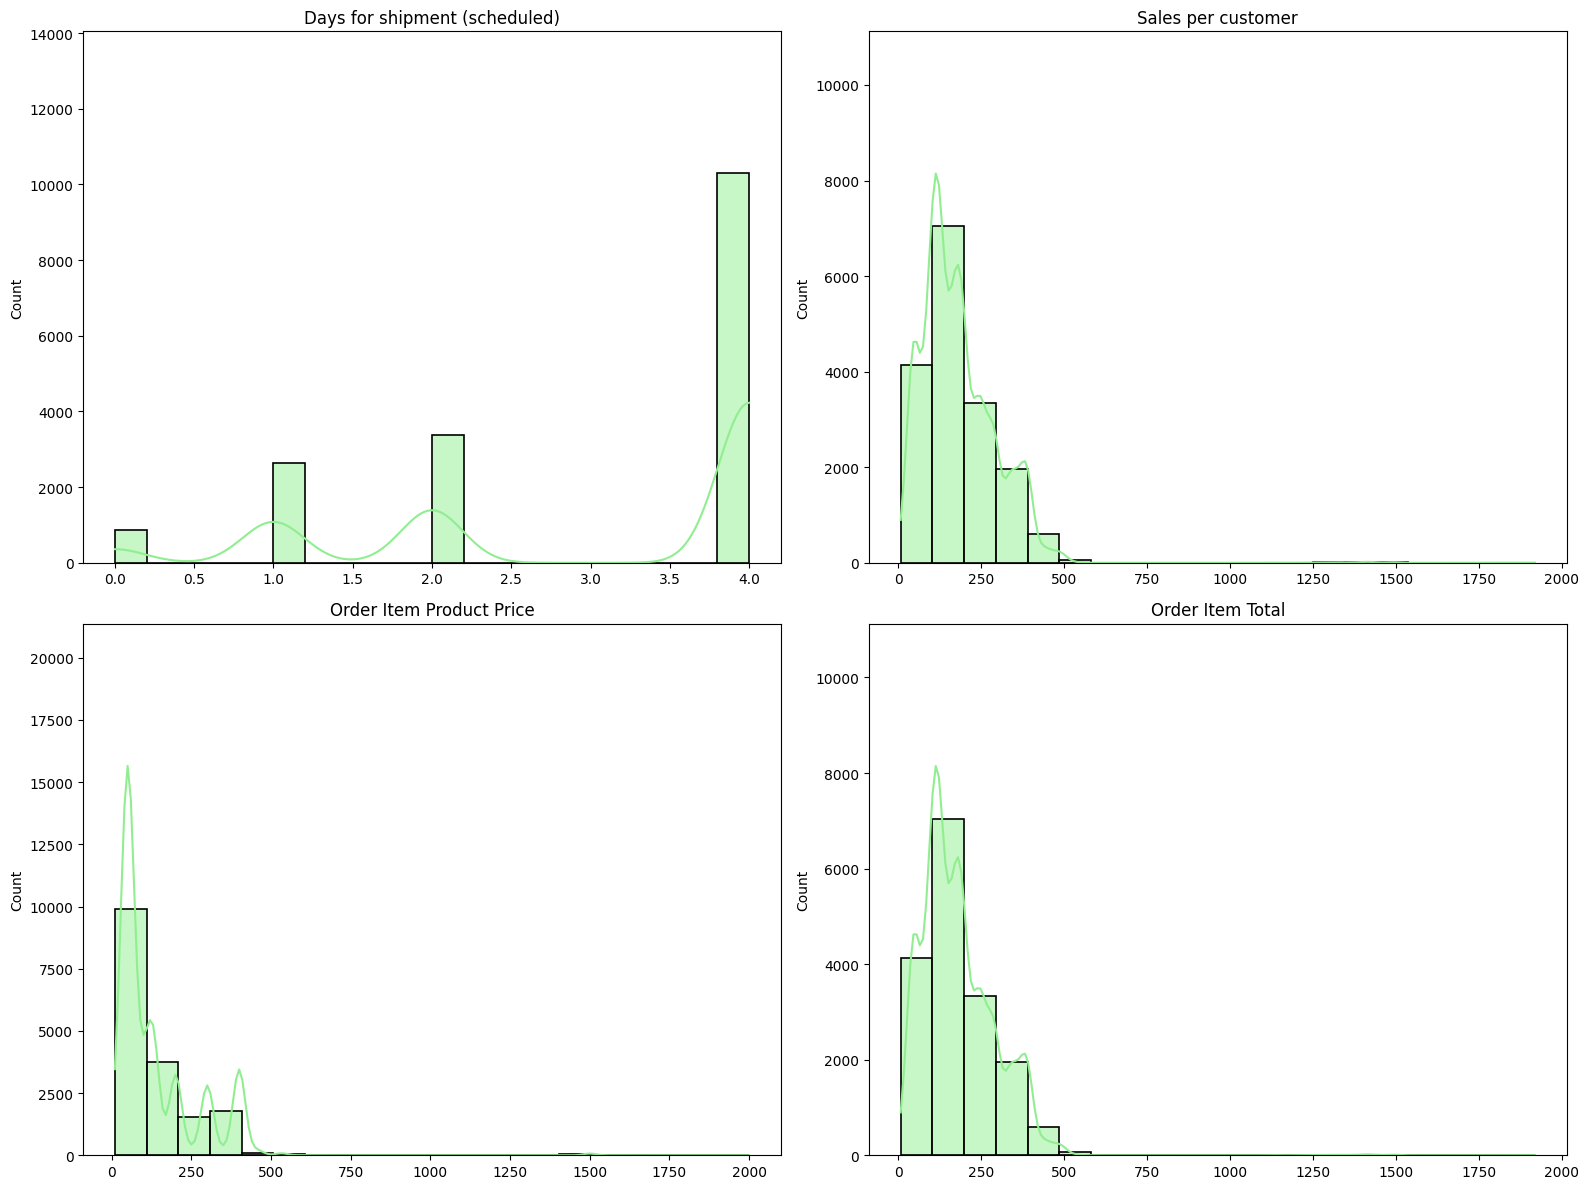

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd


df_sample = df.sample(fraction=0.1, seed=42).toPandas()

n_cols = 2  
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(16, n_rows * 6))  
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(
        df_sample[col],
        bins=20,
        kde=True,
        color="lightgreen",
        edgecolor="black",
        linewidth=1.2
    )
    plt.title(col, fontsize=12)
    plt.xlabel("")
    plt.ylabel("Count")
    plt.ylim(0, plt.gca().get_ylim()[1] * 1.3)  

plt.tight_layout()
plt.show()

### 2.3 Distribution Visualization of Numeric Features

## 3. Data Cleaning

In [10]:
# df_filled = df.na.fill(0)
df = df.drop("Product Description" , "Order Zipcode")

df.describe().show()

+-------+--------+------------------------+-----------------------------+------------------+------------------+----------------+-------------------+------------------+------------------+-------------+----------------+--------------+--------------+-----------------+--------------+-----------------+----------------+------------------+---------------+-----------------+------------------+---------------+-----------------+------------------+------+--------------+-------------+-----------------+-----------------------+------------------+----------------------+-------------------+------------------------+-----------------+------------------------+-----------------------+-------------------+-----------------+------------------+----------------------+--------------+--------------+------------+------------------+-------------------+--------------------+--------------------+------------------+--------------+--------------------------+--------------+
|summary|    Type|Days for shipping (real)|Days

In [11]:
from pyspark.sql.functions import col, isnan, when, count , sum

null_counts = df.select([sum(col(c).isNull().cast('int')).alias(c) for c in df.columns])
null_counts.show()




+----+------------------------+-----------------------------+-----------------+------------------+---------------+------------------+-----------+-------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+---------------+----------------+-------------+---------------+--------+---------+------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----+----------------+----------------------+------------+-----------+------------+---------------+-------------------+-------------+------------+-------------+--------------+--------------------------+-------------+
|Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|Delivery Status|Late_delivery_risk|Category Id|Category Name|Customer C

## calculating the distance


In [12]:
# import pandas as pd
# from pyspark.sql.functions import col
# import pickle
# from pathlib import Path
# from tqdm import tqdm
# from geopy.geocoders import Nominatim
# from geopy.extra.rate_limiter import RateLimiter
# import time

# # ========================================
# # STEP 1: GET UNIQUE LOCATIONS
# # ========================================
# unique_locations = df.select("Order City", "Order State", "Order Country").distinct()
# locations_pdf = unique_locations.toPandas()

# # Clean data - remove empty/null values
# locations_pdf = locations_pdf.dropna(subset=['Order City', 'Order State', 'Order Country'])
# locations_pdf = locations_pdf[locations_pdf['Order City'].str.strip() != '']
# locations_pdf = locations_pdf.reset_index(drop=True)

# print(f"Unique locations to geocode: {len(locations_pdf)}")

# # ========================================
# # STEP 2: LOAD OR CREATE CACHE
# # ========================================
# cache_file = "geocode_cache.pkl"

# if Path(cache_file).exists():
#     print("✓ Loading cached geocoding results...")
#     cached_data = pd.read_pickle(cache_file)
    
#     # Merge with cached data
#     locations_pdf = locations_pdf.merge(
#         cached_data[['Order City', 'Order State', 'Order Country', 'Latitude', 'Longitude']],
#         on=['Order City', 'Order State', 'Order Country'],
#         how='left'
#     )
    
#     # Find rows that still need geocoding
#     missing_mask = locations_pdf['Latitude'].isna()
#     missing_count = missing_mask.sum()
    
#     if missing_count == 0:
#         print(f"✓ All {len(locations_pdf)} locations found in cache!")
#     else:
#         print(f"✓ Found {len(locations_pdf) - missing_count} cached locations")
#         print(f"⚠ Need to geocode {missing_count} new locations...")
# else:
#     print("⚠ No cache found. Will geocode all locations...")
#     locations_pdf['Latitude'] = None
#     locations_pdf['Longitude'] = None
#     missing_mask = pd.Series([True] * len(locations_pdf))
#     missing_count = len(locations_pdf)

# # ========================================
# # STEP 3: GEOCODE MISSING LOCATIONS (FREE)
# # ========================================
# if missing_count > 0:
#     print(f"\nStarting FREE geocoding for {missing_count} locations using Nominatim (OpenStreetMap)...")
#     print(f"⏱ Estimated time: ~{missing_count / 60:.1f} minutes (respecting 1 req/sec rate limit)")
#     print("☕ This is a one-time process. Grab a coffee and let it run!")
#     print("💾 Results will be cached - future runs will be instant!\n")
    

#     geolocator = Nominatim(
#         user_agent="my_bigdata_geocoder_v1",  # Can be any unique name
#         timeout=10
#     )
    
#     # Rate limiter to respect OpenStreetMap's usage policy (1 request per second)
#     geocode_safe = RateLimiter(
#         geolocator.geocode, 
#         min_delay_seconds=1.0,  # Wait 1 second between requests
#         max_retries=3
#     )
    
#     def geocode_location(row):
#         try:
#             # Create address string
#             address = f"{row['Order City']}, {row['Order State']}, {row['Order Country']}"
            
#             # Geocode
#             location = geocode_safe(address)
            
#             if location:
#                 return pd.Series([location.latitude, location.longitude])
#         except Exception as e:
#             # Silent fail - will return None, None
#             pass
#         return pd.Series([None, None])
    
#     # Geocode with progress bar
#     tqdm.pandas(desc="🌍 Geocoding")
    
#     # Process only missing locations
#     result = locations_pdf[missing_mask].progress_apply(geocode_location, axis=1)
#     locations_pdf.loc[missing_mask, ['Latitude', 'Longitude']] = result
    
#     # Save updated cache
#     locations_pdf.to_pickle(cache_file)
#     print(f"\n✓ Geocoding complete! Results cached to {cache_file}")
    
#     # Show success rate
#     success_count = locations_pdf['Latitude'].notna().sum()
#     print(f"✓ Successfully geocoded: {success_count}/{len(locations_pdf)} locations ({success_count/len(locations_pdf)*100:.1f}%)")
#     print(f"✓ Failed/Not found: {len(locations_pdf) - success_count} locations")

# # ========================================
# # STEP 4: JOIN BACK TO ORIGINAL DATAFRAME
# # ========================================
# print("\nJoining geocoded data back to main DataFrame...")
# lookup_df = spark.createDataFrame(locations_pdf)
# final_df = df.join(
#     lookup_df, 
#     on=["Order City", "Order State", "Order Country"], 
#     how="left"
# )

# print("✓ Done! Showing sample results:")
# final_df.select("Order City", "Order State", "Order Country", "Latitude", "Longitude").show(20)

# # Optional: Save the final result
# # final_df.write.parquet("orders_with_geocodes.parquet", mode="overwrite")

# print("\n" + "="*60)
# print("✅ ALL OPERATIONS COMPLETE!")
# print("="*60)
# print(f"💾 Cache saved: {cache_file}")
# print(f"⚡ Next run will be INSTANT (loads from cache)")
# print("="*60)

In [13]:
unique_locations = df.select("Order City", "Order State", "Order Country").distinct()
unique_locations.count()

3758

### 3.1 Verify Missing Values After Cleaning

In [14]:
df.count()

172765

### 3.2 Feature Selection - Drop Unnecessary Columns

In [15]:
columns_to_drop = ["Customer Email" , "Customer Fname" , "Customer Id" , "Customer Lname" , "Customer Password" , "Customer Segment" , "Customer State" , "Customer Street" , "Customer Zipcode" , "Department Name" ,  "Order Customer Id" , "Order Item Product Price" , "Order Item Profit Ratio"   , "Order Profit Per Order"  , "Product Image" , "Product Name" , "Order Item Cardprod Id" , "Order Item Discount" , "Order Item Id" , "Product Card Id"  , "Sales"  , "Departement id" , "Category id" , "Category name" , "Order item total" , "Order id" , "Days for shipping (real)" , "Delivery Status" , "order date (DateOrders)"] 

len(columns_to_drop)

29

In [16]:
df_cleaned = df.drop(*columns_to_drop)
df_cleaned.show(5)


+--------+-----------------------------+-----------------+------------------+------------------+-------------+----------------+-------------+-----------+------------+------------+----------+-------------+------------------------+-------------------+--------------+---------------+---------------+-------------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipment (scheduled)|Benefit per order|Sales per customer|Late_delivery_risk|Customer City|Customer Country|Department Id|   Latitude|   Longitude|      Market|Order City|Order Country|Order Item Discount Rate|Order Item Quantity|  Order Region|    Order State|   Order Status|Product Category Id|Product Price|Product Status|shipping date (DateOrders)| Shipping Mode|
+--------+-----------------------------+-----------------+------------------+------------------+-------------+----------------+-------------+-----------+------------+------------+----------+-------------+--------------------

## 4. Exploratory Data Analysis (EDA)

In [17]:
# from boruta import BorutaPy
# from sklearn.ensemble import RandomForestClassifier
# import numpy as np


# df_cleaned_pandas = df_cleaned.toPandas()


# X = df_cleaned_pandas.drop('Late_delivery_risk', axis=1)
# y = df_cleaned_pandas['Late_delivery_risk']

# from sklearn.preprocessing import LabelEncoder

# categorical_cols = X.select_dtypes(include=['object']).columns
# label_encoders = {}

# for col in categorical_cols:
#     le = LabelEncoder()
#     X[col] = le.fit_transform(X[col].astype(str))
#     label_encoders[col] = le

# # Handle any remaining non-numeric columns
# X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# # Initialize Random Forest classifier
# rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=42)

# # Initialize Boruta
# boruta_selector = BorutaPy(rf, n_estimators='auto', random_state=42, verbose=2, max_iter=100)

# # Fit Boruta
# print("Running Boruta feature selection...")
# boruta_selector.fit(X.values, y.values)

# selected_features = X.columns[boruta_selector.support_].tolist()
# tentative_features = X.columns[boruta_selector.support_weak_].tolist()

# print(f"\n=== Boruta Results ===")
# print(f"Number of selected features: {len(selected_features)}")
# print(f"Selected features: {selected_features}")
# print(f"\nNumber of tentative features: {len(tentative_features)}")
# print(f"Tentative features: {tentative_features}")

# # ✅ Refit RandomForest on all data to get feature importances
# rf.fit(X.values, y.values)
# importances = rf.feature_importances_

# # Create DataFrame with importances as percentages
# importance_df = pd.DataFrame({
#     'Feature': X.columns,
#     'Importance (%)': 100 * importances / importances.sum(),
#     'Ranking': boruta_selector.ranking_,
#     'Selected': boruta_selector.support_
# }).sort_values('Importance (%)', ascending=False)

# print("\n=== Feature Importances (% of total) ===")
# print(importance_df)

In [18]:
# print("\n=== Feature Importances (% of total) ===")
# print(importance_df)

### 3.3 Feature Selection using Boruta

Apply Boruta algorithm to identify the most important features for predicting late delivery risk.

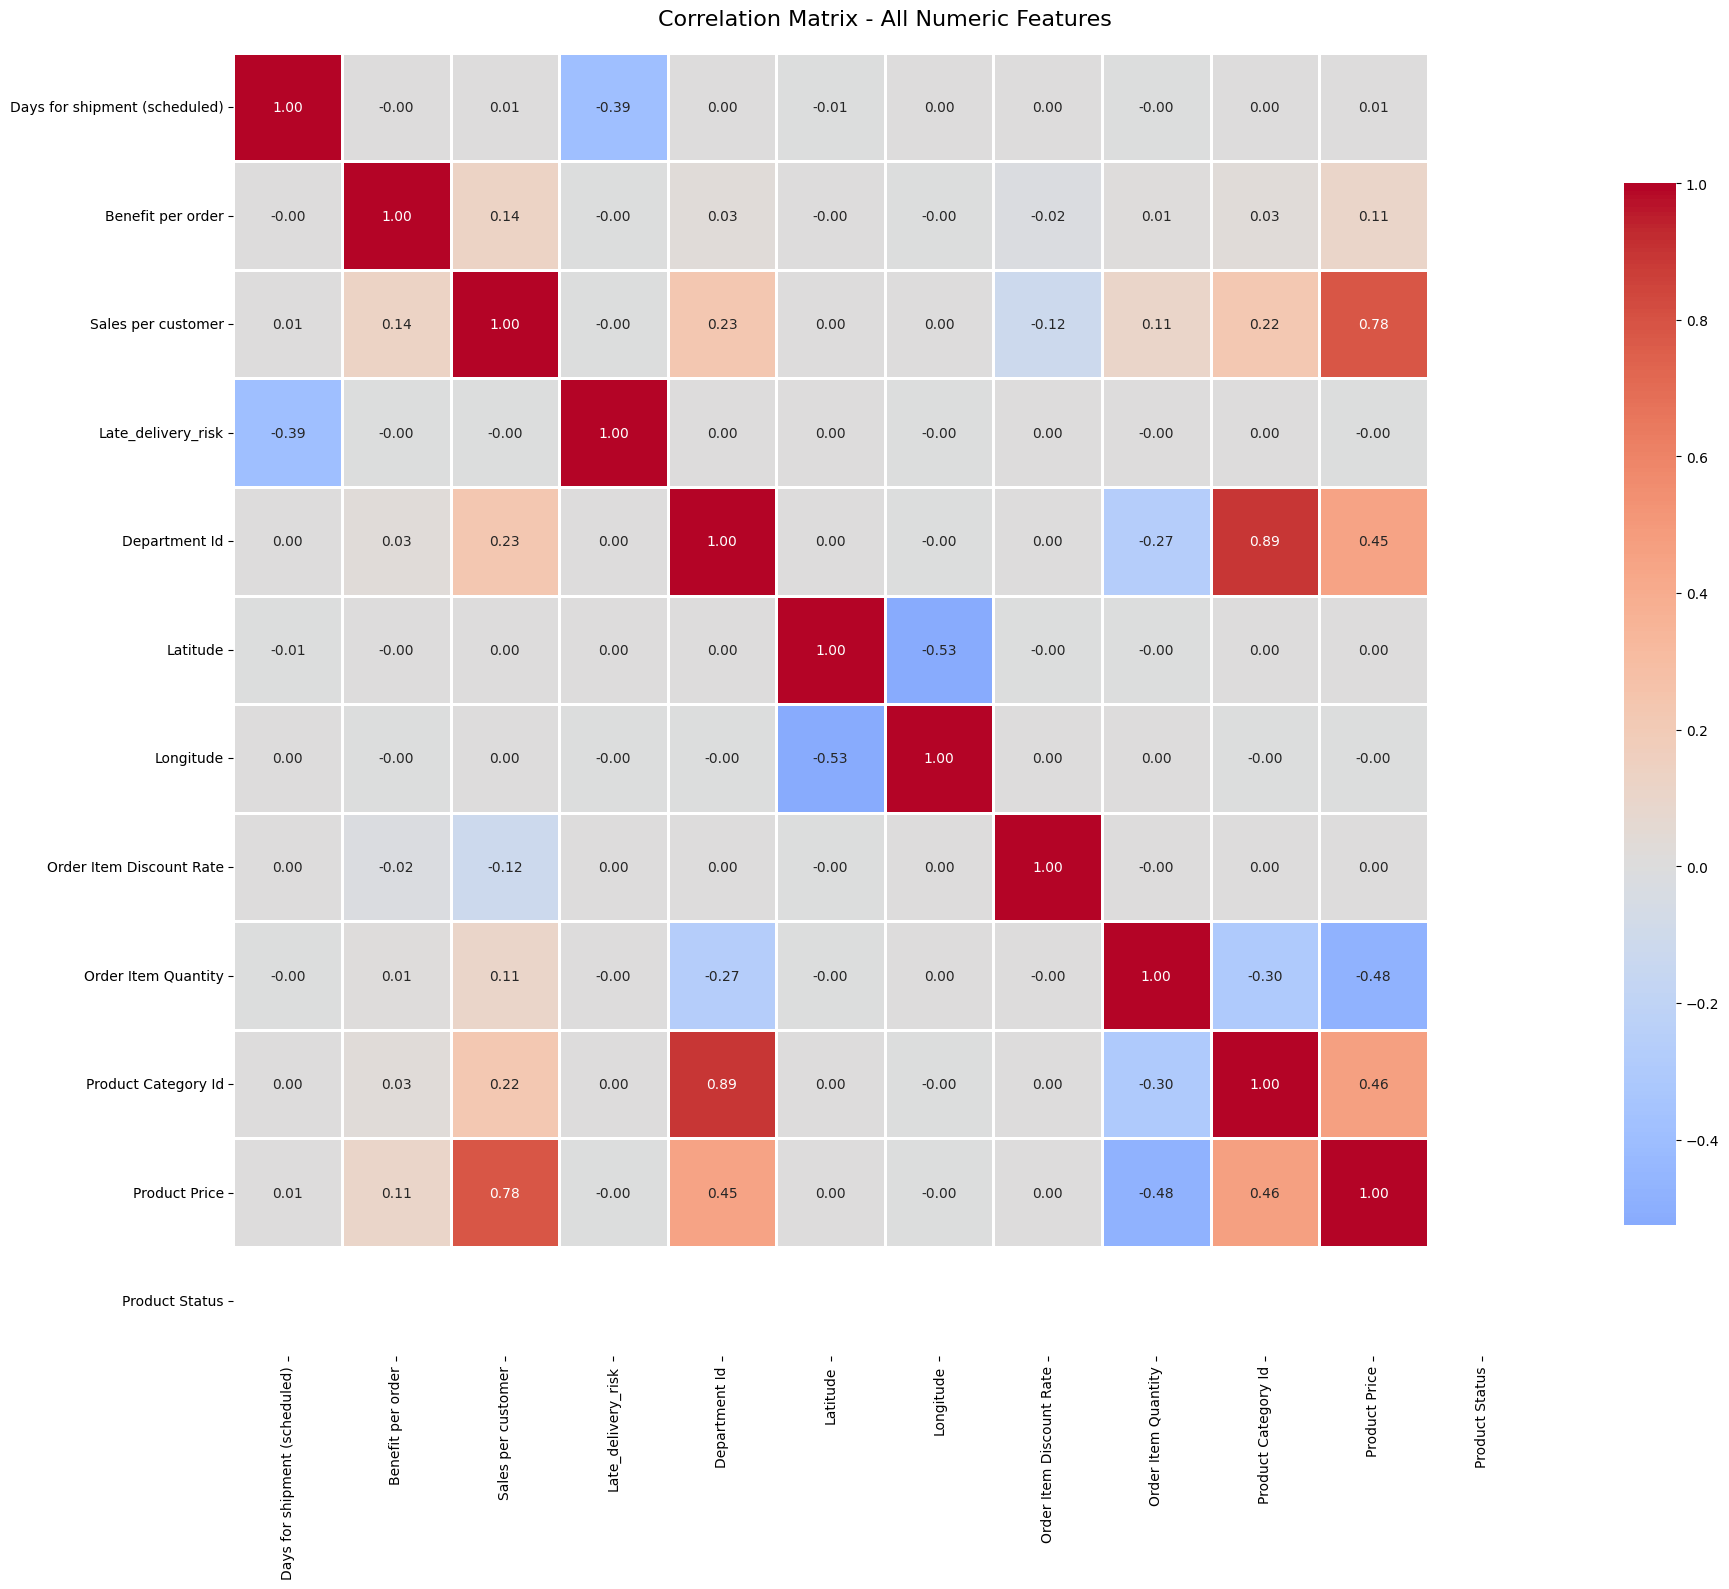

In [19]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df_pandas = df_cleaned.toPandas()


numeric_df = df_pandas.select_dtypes(include=['int', 'float', 'double'])


correlation_matrix = numeric_df.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - All Numeric Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

### 4.1 Correlation Matrix - All Numeric Features

In [20]:
from pyspark.sql.functions import col

duplicate_counts = (
    df_cleaned.groupBy(df_cleaned.columns)
    .count()
    .filter(col("count") > 1)
)

duplicate_counts.show()

+----+-----------------------------+-----------------+------------------+------------------+-------------+----------------+-------------+--------+---------+------+----------+-------------+------------------------+-------------------+------------+-----------+------------+-------------------+-------------+--------------+--------------------------+-------------+-----+
|Type|Days for shipment (scheduled)|Benefit per order|Sales per customer|Late_delivery_risk|Customer City|Customer Country|Department Id|Latitude|Longitude|Market|Order City|Order Country|Order Item Discount Rate|Order Item Quantity|Order Region|Order State|Order Status|Product Category Id|Product Price|Product Status|shipping date (DateOrders)|Shipping Mode|count|
+----+-----------------------------+-----------------+------------------+------------------+-------------+----------------+-------------+--------+---------+------+----------+-------------+------------------------+-------------------+------------+-----------+------

In [21]:
duplicate_counts.show()

numeric_types = ['int', 'float', 'double', 'decimal']

numeric_columns = [col for col , type in df_cleaned.dtypes if type in numeric_types]
numeric_columns.remove("Late_delivery_risk")
numeric_columns


date_columns = ["shipping date (DateOrders)" , "order date (DateOrders)"]

+----+-----------------------------+-----------------+------------------+------------------+-------------+----------------+-------------+--------+---------+------+----------+-------------+------------------------+-------------------+------------+-----------+------------+-------------------+-------------+--------------+--------------------------+-------------+-----+
|Type|Days for shipment (scheduled)|Benefit per order|Sales per customer|Late_delivery_risk|Customer City|Customer Country|Department Id|Latitude|Longitude|Market|Order City|Order Country|Order Item Discount Rate|Order Item Quantity|Order Region|Order State|Order Status|Product Category Id|Product Price|Product Status|shipping date (DateOrders)|Shipping Mode|count|
+----+-----------------------------+-----------------+------------------+------------------+-------------+----------------+-------------+--------+---------+------+----------+-------------+------------------------+-------------------+------------+-----------+------

## 5. Feature Engineering

In [22]:
numeric_types = ['int', 'float', 'double', 'decimal']

numeric_columns = [col for col , type in df_cleaned.dtypes if type in numeric_types]
numeric_columns.remove("Late_delivery_risk")
numeric_columns

date_columns = ["shipping date (DateOrders)" , "order date (DateOrders)"]

In [23]:
from pyspark.ml.feature import StandardScaler, OneHotEncoder, VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import unix_timestamp

df_with_dates = df_cleaned.withColumn(
    "shipping_date_timestamp", 
    unix_timestamp("shipping date (DateOrders)", "M/d/yyyy H:mm")
)

df_with_dates = df_with_dates.drop("shipping date (DateOrders)")

numeric_columns_with_dates = numeric_columns + [ "shipping_date_timestamp"]
categorical_columns = [col for col in df_with_dates.columns if (col not in numeric_columns_with_dates) and (col != "Late_delivery_risk")]

string_indexer = StringIndexer(
    inputCols=categorical_columns,
    outputCols=[col + "_index" for col in categorical_columns],
    handleInvalid="keep"
)

indexed_col_names = [col + "_index" for col in categorical_columns]
encoder = OneHotEncoder(
    inputCols=indexed_col_names,
    outputCols=[col + "_vec" for col in indexed_col_names]
)

assembler = VectorAssembler(
    inputCols=numeric_columns_with_dates,
    outputCol="unscaled_features"
)

scaler = StandardScaler(
    inputCol="unscaled_features",
    outputCol="scaled_numeric_features" 
)

final_feature_cols = [col + "_vec" for col in indexed_col_names] + ["scaled_numeric_features"]

final_assembler = VectorAssembler(
    inputCols=final_feature_cols,
    outputCol="features"
)

preprocessing_pipeline = Pipeline(
    stages=[
        string_indexer,
        encoder,
        assembler,
        scaler,
        final_assembler
    ]
)

preprocessing_model = preprocessing_pipeline.fit(df_with_dates)

preprocessing_model.save("preprocessing_model_spark")
df_ready_for_ml = preprocessing_model.transform(df_with_dates)

df_ready_for_ml.select("features", "Late_delivery_risk").show(5, truncate=False)

25/11/18 23:35:10 ERROR Instrumentation: java.io.IOException: Path preprocessing_model_spark already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:794)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:168)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.super$save(Pipeline.scala:368)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$4(Pipeline.scala:368)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent(events.scala:174)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent$(events.scala:169)
	at org.apache.spark.ml.util.Instrumentation.withSaveInstanceEvent(Instrumentation.scala:44)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3(Pipeline.scala:368)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3$adapted(Pipeline.scala:

Py4JJavaError: An error occurred while calling o1402.save.
: java.io.IOException: Path preprocessing_model_spark already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:794)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:168)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.super$save(Pipeline.scala:368)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$4(Pipeline.scala:368)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent(events.scala:174)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent$(events.scala:169)
	at org.apache.spark.ml.util.Instrumentation.withSaveInstanceEvent(Instrumentation.scala:44)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3(Pipeline.scala:368)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3$adapted(Pipeline.scala:368)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:226)
	at scala.util.Try$.apply(Try.scala:217)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:226)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.save(Pipeline.scala:368)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:840)


25/11/19 10:00:21 WARN TransportChannelHandler: Exception in connection from /192.168.11.116:43733
java.io.IOException: Connection timed out
	at java.base/sun.nio.ch.SocketDispatcher.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:47)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:330)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:284)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:259)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:417)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:255)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:356)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:796)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOpt

### 5.1 Numeric Feature Scaling and Categorical Encoding

In [ ]:
from pyspark.ml.stat import Correlation

print("\n--- Calculating Correlation Matrix ---")

corr_assembler = VectorAssembler(
    inputCols=indexed_col_names,
    outputCol="corr_features"
)

df_corr_vector = corr_assembler.transform(df_ready_for_ml).select("corr_features")

print("Calculating matrix...")
corr_matrix_df = Correlation.corr(df_corr_vector, "corr_features", "pearson")

corr_matrix = corr_matrix_df.collect()[0][0]

print("\nSpark Correlation Matrix (as a dense matrix):")
print(corr_matrix)

print("\nColumns in the matrix (in order):")
for i, col in enumerate(indexed_col_names):
    print(f"{i}: {col}")


--- Calculating Correlation Matrix ---
Calculating matrix...



Spark Correlation Matrix (as a dense matrix):
DenseMatrix([[ 1.00000000e+00, -2.18992037e-03,  1.08081587e-03,
              -8.45668227e-03, -7.27466240e-03, -5.36080060e-03,
              -5.37816212e-03, -1.00112615e-02,  4.68811774e-01,
               2.32504809e-04],
             [-2.18992037e-03,  1.00000000e+00, -4.77196779e-01,
               6.56253988e-03,  1.29813476e-03,  3.07099262e-03,
               5.26297475e-03, -7.06083033e-04,  6.97619078e-03,
               2.50893465e-03],
             [ 1.08081587e-03, -4.77196779e-01,  1.00000000e+00,
              -1.17025498e-02, -1.86229045e-03, -4.88544348e-03,
              -7.51428706e-03, -2.65451559e-03, -4.78689289e-03,
              -5.44959638e-03],
             [-8.45668227e-03,  6.56253988e-03, -1.17025498e-02,
               1.00000000e+00,  1.02419302e-01,  1.34295014e-01,
               7.92799706e-01,  1.48863263e-01, -9.12849975e-03,
               5.55287562e-03],
             [-7.27466240e-03,  1.29813476e-0

### 5.2 Correlation Analysis

In [ ]:
encoded_feature_cols = [col + "_vec" for col in indexed_col_names]
final_cols = ["features"] + encoded_feature_cols + ["Late_delivery_risk"]

df_final = df_ready_for_ml.select(final_cols)
df_final.show(5)

+--------------------+--------------+-----------------------+--------------------------+----------------+--------------------+-----------------------+----------------------+---------------------+----------------------+-----------------------+------------------+
|            features|Type_index_vec|Customer City_index_vec|Customer Country_index_vec|Market_index_vec|Order City_index_vec|Order Country_index_vec|Order Region_index_vec|Order State_index_vec|Order Status_index_vec|Shipping Mode_index_vec|Late_delivery_risk|
+--------------------+--------------+-----------------------+--------------------------+----------------+--------------------+-----------------------+----------------------+---------------------+----------------------+-----------------------+------------------+
|(5452,[0,4,568,57...| (4,[0],[1.0])|        (563,[0],[1.0])|             (2,[1],[1.0])|   (5,[2],[1.0])|  (3585,[169],[1.0])|       (164,[10],[1.0])|        (23,[5],[1.0])|    (1083,[45],[1.0])|         (7,[0],[1.

### 5.3 Visualize Correlation Matrix

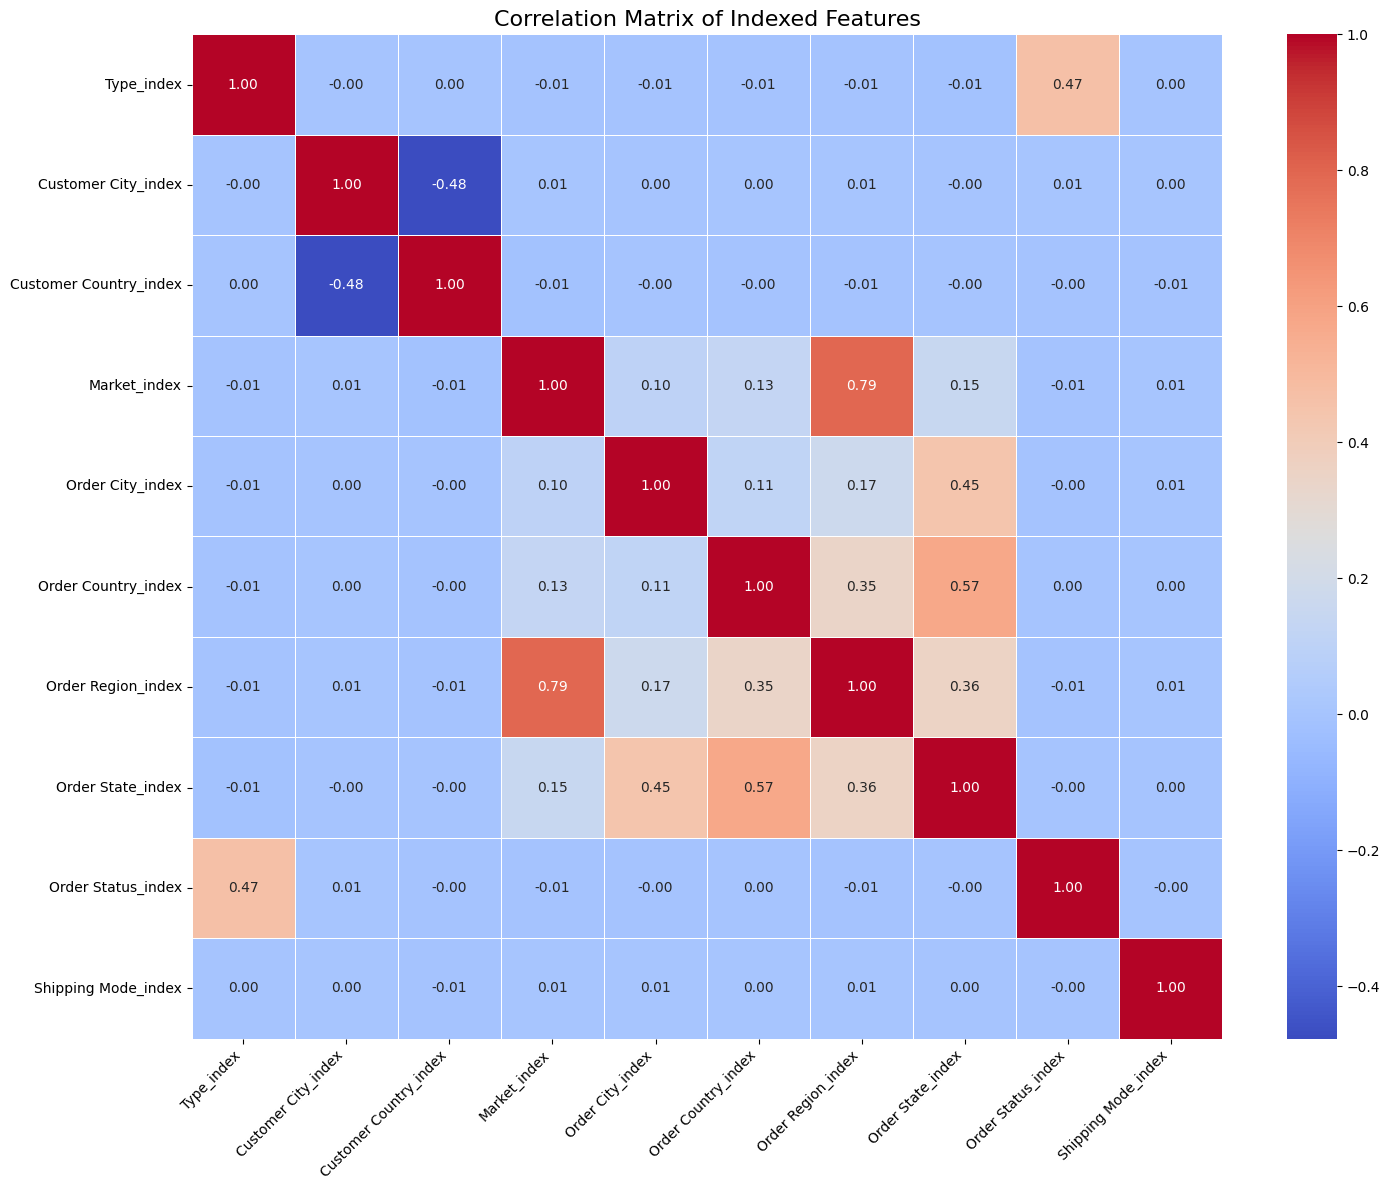

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

corr_array = corr_matrix.toArray()
pandas_df = pd.DataFrame(
    corr_array, 
    index=indexed_col_names, 
    columns=indexed_col_names
)

plt.figure(figsize=(15, 12))
heatmap = sns.heatmap(
    pandas_df,
    annot=True,      
    fmt='.2f',      
    cmap='coolwarm',
    linewidths=.5   
)
plt.title('Correlation Matrix of Indexed Features', fontsize=16)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.tight_layout()

## 6. Final Feature Assembly

Combine all features into a single vector for modeling.

In [ ]:
# The final features are already assembled in df_ready_for_ml
# Select only the features and label columns for modeling
df_ready = df_ready_for_ml.select("features", "Late_delivery_risk")

df_ready.show(3, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|features                                                                                                                                                                                                                                                                                                                                                           |Late_delivery_risk|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.sql.functions import col

print(f" the nupmber of high risk is : {df_ready.filter(col("Late_delivery_risk") == 1).count()}")
print(f" the nupmber of low risk is : {df_ready.filter(col("Late_delivery_risk") == 0).count()}")

 the nupmber of high risk is : 98977
 the nupmber of low risk is : 73788


In [ ]:
(training_data , test_data) = df_ready.randomSplit([0.7 , 0.3] , seed=42)

In [ ]:
print(df_cleaned.filter(col("Late_delivery_risk") == 1).count())
print(df_cleaned.filter(col("Late_delivery_risk") == 0).count())

98977
73788


## 🔧 Memory Optimization

Apply caching and Spark configuration to prevent memory warnings and improve performance.

In [ ]:
# ========================================
# SOLUTION TO MEMORY WARNINGS
# ========================================

# 1. Cache the preprocessed data to avoid recomputation
print("📦 Caching preprocessed data...")
df_ready.cache()
df_ready.count()  # Trigger cache materialization

# 2. Update Spark configuration for better memory management
# Note: Some configs like spark.serializer can only be set at session creation
print("\n⚙️ Updating Spark configuration...")
spark.conf.set("spark.sql.shuffle.partitions", "100")  # Reduce from default 200
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", "10485760")  # 10MB threshold

# 3. Repartition data for optimal parallel processing
print("🔄 Repartitioning data...")
df_ready = df_ready.repartition(8)  # Adjust based on your CPU cores
df_ready.cache()

print("\n✅ Optimizations applied!")
print(f"   ✓ Data cached in memory")
print(f"   ✓ Shuffle partitions reduced to 100")
print(f"   ✓ Data repartitioned to 8 partitions")
print(f"   ✓ Broadcast threshold: 10 MB")
print("\n💡 This should eliminate the 'Broadcasting large task binary' warnings!")
print("   (Serializer configs require session restart - not critical for this fix)")

📦 Caching preprocessed data...



⚙️ Updating Spark configuration...
🔄 Repartitioning data...

✅ Optimizations applied!
   ✓ Data cached in memory
   ✓ Shuffle partitions reduced to 100
   ✓ Data repartitioned to 8 partitions
   ✓ Broadcast threshold: 10 MB

💡 This should eliminate the 'Broadcasting large task binary' warnings!
   (Serializer configs require session restart - not critical for this fix)


In [ ]:
from pyspark.ml.classification import (
    RandomForestClassifier,
    LogisticRegression,
    GBTClassifier
)
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


rf = RandomForestClassifier(featuresCol="features", labelCol="Late_delivery_risk")
lr = LogisticRegression(featuresCol="features", labelCol="Late_delivery_risk")
gbt = GBTClassifier(featuresCol="features", labelCol="Late_delivery_risk")



(trainingData, testData) = df_ready.randomSplit([0.8, 0.2], seed=42)


rf_model = rf.fit(trainingData)
lr_model = lr.fit(trainingData)
gbt_model = gbt.fit(trainingData)


rf_pred = rf_model.transform(testData)
lr_pred = lr_model.transform(testData)
gbt_pred = gbt_model.transform(testData)




In [ ]:
rf_pred.show()

+--------------------+------------------+--------------------+--------------------+----------+
|            features|Late_delivery_risk|       rawPrediction|         probability|prediction|
+--------------------+------------------+--------------------+--------------------+----------+
|(5452,[0,4,568,56...|                 1|[9.53261978810153...|[0.47663098940507...|       1.0|
|(5452,[0,4,568,56...|                 1|[9.53261978810153...|[0.47663098940507...|       1.0|
|(5452,[0,4,568,56...|                 1|[9.53261978810153...|[0.47663098940507...|       1.0|
|(5452,[0,4,568,56...|                 0|[9.53261978810153...|[0.47663098940507...|       1.0|
|(5452,[0,4,568,56...|                 1|[9.53261978810153...|[0.47663098940507...|       1.0|
|(5452,[0,4,568,56...|                 0|[9.53261978810153...|[0.47663098940507...|       1.0|
|(5452,[0,4,568,56...|                 1|[6.62223930820589...|[0.33111196541029...|       1.0|
|(5452,[0,4,568,56...|                 0|[8.044979

In [ ]:

print("📊 Caching model predictions...")
rf_pred.cache()
lr_pred.cache()
gbt_pred.cache()


rf_pred.count()
lr_pred.count()
gbt_pred.count()

print("✅ All predictions cached!")

📊 Caching model predictions...
✅ All predictions cached!


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator


auc_eval = BinaryClassificationEvaluator(
    labelCol="Late_delivery_risk",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)


def evaluate_binary_model(pred):

    tp = pred.filter("prediction = 1 AND Late_delivery_risk = 1").count()
    tn = pred.filter("prediction = 0 AND Late_delivery_risk = 0").count()
    fp = pred.filter("prediction = 1 AND Late_delivery_risk = 0").count()
    fn = pred.filter("prediction = 0 AND Late_delivery_risk = 1").count()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0


    auc = auc_eval.evaluate(pred)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc
    }


print("Random Forest:", evaluate_binary_model(rf_pred))
print("Logistic Regression:", evaluate_binary_model(lr_pred))
print("Gradient Boosted Trees:", evaluate_binary_model(gbt_pred))


Random Forest: {'accuracy': 0.5744158878504673, 'precision': 0.5737426403819679, 'recall': 0.998979956138114, 'f1': 0.7288728463513564, 'auc': 0.7492632957494493}
Logistic Regression: {'accuracy': 0.7239485981308411, 'precision': 0.8061501356647574, 'recall': 0.6818993216708319, 'f1': 0.7388373121131743, 'auc': 0.7987407052093071}
Gradient Boosted Trees: {'accuracy': 0.7049941588785047, 'precision': 0.8792690711777849, 'recall': 0.5619931657061253, 'f1': 0.6857089517408755, 'auc': 0.7548140129377713}


In [ ]:
# # TRAIN METRIC
# train_pred_rf = rf_model.transform(train_data)
# train_auc_rf = auc_eval.evaluate(train_pred_rf)

# # TEST METRIC
# test_auc_rf = auc_eval.evaluate(rf_pred)

# print("RF Train AUC:", train_auc_rf)
# print("RF Test AUC:", test_auc_rf)


In [ ]:
auc_eval = BinaryClassificationEvaluator(
    labelCol="Late_delivery_risk",
    rawPredictionCol="probability",
    metricName="areaUnderROC"
)

print("RF AUC:", auc_eval.evaluate(rf_pred))
print("LR AUC:", auc_eval.evaluate(lr_pred))
print("GBT AUC:", auc_eval.evaluate(gbt_pred))


RF AUC: 0.7492632957494493
LR AUC: 0.7987374968775404
GBT AUC: 0.7548140338503085


In [ ]:
print("saving the model : ")
gbt_model.save("gbt_model_spark")

saving the model : 


In [ ]:
df_cleaned.columns

['Type',
 'Days for shipment (scheduled)',
 'Benefit per order',
 'Sales per customer',
 'Late_delivery_risk',
 'Customer City',
 'Customer Country',
 'Department Id',
 'Latitude',
 'Longitude',
 'Market',
 'Order City',
 'Order Country',
 'Order Item Discount Rate',
 'Order Item Quantity',
 'Order Region',
 'Order State',
 'Order Status',
 'Product Category Id',
 'Product Price',
 'Product Status',
 'shipping date (DateOrders)',
 'Shipping Mode']